## Sampling probability distributions

There are many applications in which one wishes to draw samples from probability distributions.  For example, the function `np.random.randn(t)` draws samples from the "standard normal", or Gaussian, distribution.

$$ p(t) = \frac{1}{\sqrt{2\pi}} e^{-t^2/2} . $$

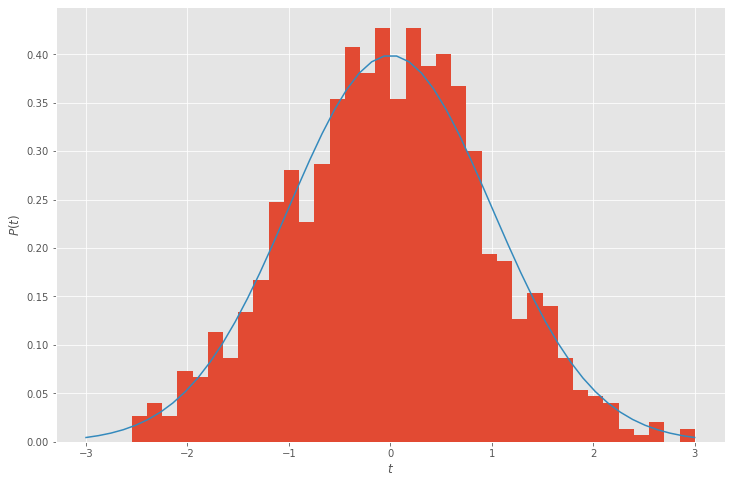

In [19]:
%matplotlib inline
import pandas
import seaborn
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rc('figure', figsize=(12,8))

def stdnormal(t):
    return np.exp(-t**2/2) / np.sqrt(2*np.pi)

n = 1000
w = np.random.randn(n)
plt.hist(w, bins=40, range=(-3,3), density=True)
t = np.linspace(-3, 3)
plt.plot(t, stdnormal(t))
plt.xlabel('$t$')
plt.ylabel('$P(t)$');

### Statistics for Hackers

Statistical simulation as a simpler surrogate for tedious analysis (also a primer for more advanced methods in which analysis is intractable):

* [Notebook](http://christopherroach.com/articles/statistics-for-hackers/) version of [this talk](https://youtu.be/Iq9DzN6mvYA) ([slides](https://speakerdeck.com/jakevdp/statistics-for-hackers))

### Transforming

To say that our sample $w$ is draw from a standard normal distribution, we write

$$ w \sim \mathcal N(0,1) . $$

How do we generate samples of a distribution with nonzero mean or non-unit variance?

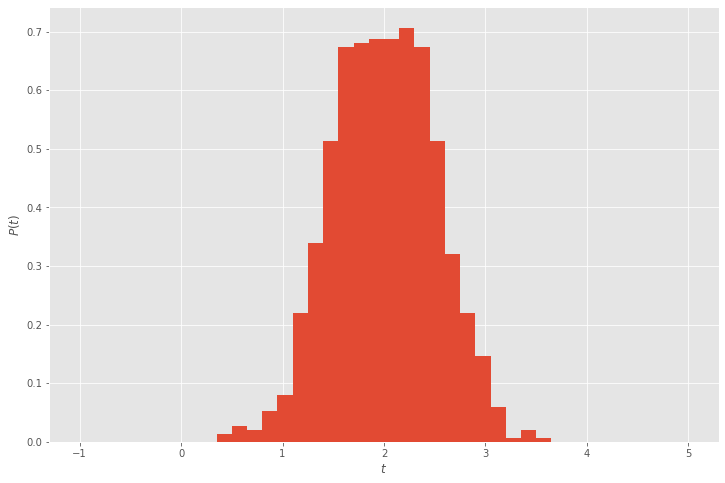

In [20]:
import statsmodels

n = 1000
w = 2 + .5*np.random.randn(n)
plt.hist(w, bins=40, range=(-1,5), density=True)
plt.xlabel('$t$')
plt.ylabel('$P(t)$');

### Multivariate distributions

Sometimes we have multiple variables that are related, such as the temperature in different cities.  On any given day, we observe the weather in Boulder, Denver, Fort Collins, and Seattle.  What is the probability of any given observation?

For convenience, suppose that each distribution is independently a Gaussian distribution.  Taking products, we can motivate a linear algebraic formulation,

$$ e^{-s^2/2} e^{-t^2/2} = e^{-\frac 1 2 \begin{bmatrix} s & t \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} s \\ t \end{bmatrix}} $$

More generally, we may express a multidimensional distribution for $\mathbf x$ with mean $\mathbf \mu$ and covariance matrix $\Sigma$ as

$$ P(\mathbf x) = \frac 1 Z e^{-\frac 1 2 (\mathbf x - \mathbf \mu)^T \Sigma^{-1} (\mathbf x - \mathbf \mu)} $$

where $Z$ is a normalizing factor necessary for the integral to equal 1.  Covaniance matrices are symmetric positive definite, and rarely sparse, though they may have exploitable structure (such as low-rank off-diagonal blocks).

Many statistical computations involve

* drawing samples from such distributions (bootstrapping, etc., and Bayesian Monte-Carlo methods)
* optimizing parameters (such as $\mathbf \mu$ and $\Sigma$) over a training set of observations (maximum likelihood estimation and variational inference)

#### Negative log

Probabilities become inconveniently small when far from the mean.

In [21]:
stdnormal(10)

7.69459862670642e-23

Taking the negative log provides a more convenient expression

$$ -\log P(\mathbf x) = \frac 1 2 (\mathbf x - \mathbf \mu)^T \Sigma^{-1} (\mathbf x - \mathbf \mu) + \log Z $$

which involves a quadratic matrix expression (convenient for optimization) plus a regularization term.

#### Normalization

It can be shown that the normalization factor has the form

$$ Z = \sqrt{\det(2 \pi \Sigma)} . $$

In some circumstances, such as when estimating $\mathbf \mu$ given known $\Sigma$, it is not necessary to evaluate or optimize the determinant.  In other settings, it is necessary and a nontrivial cost.
Computing the determinant is typically done via factorization, such as

$$ L L^T = \Sigma $$

or

$$ L L^T = \Sigma^{-1} $$

if one is working directly with the "precision matrix" $\Sigma^{-1}$.  This can be advantageous when the precision matrix is sparse, which represents conditional independence and is common even when the covariance matrix is dense.

For example, the weather in Boulder is conditionally independent of the weather in Seattle: if we know the weather in Denver and Fort Collins, adding knowledge of the weather in Seattle provides us no additional information about the weather in Boulder.  This leads to a zero in $\Sigma^{-1}$.

However, knowing the weather in Seattle might help determine whether it is summer or winter, or whether we're in an El Niño year.  This leads to a nonzero entry in $\Sigma$.

#### Sampling

We wish to draw samples such that the expected covariance matches our $\Sigma$,

$$ \mathbb E\Big[ (\mathbf x - \mathbf \mu) (\mathbf x - \mathbf \mu)^T \Big] = \Sigma . $$

For this, we seek a transformation $\mathbf x = \mu + T \mathbf y$ such that each entry of $y \sim \mathcal N(0,1)$.  To this end,

$$ \Sigma = \mathbb E\Big[ T \mathbf y \mathbf y^T T^T \Big] = T \mathbb E[\mathbf y \mathbf y^T] T^T = T T^T $$
so we need to determine such a matrix $T$.

One approach is eigendecomposition,

$$ \Sigma = Q \Lambda Q^T = \big(Q \sqrt{\Lambda} \big) \big(Q \sqrt{\Lambda} \big)^T $$

and another is Cholesky factorization

$$ \Sigma = L L^T, $$

which is generally more efficient (if perhaps less intuitive).

## Gaussian processes

A Gaussian process is a probability model for continuous independent variables.  In the temperature example, we might consider latitude and longitude as independent variables.  Given any finite sample of locations (Boulder, Denver, etc.), we build a covariance matrix between any two points $u$ and $v$ by evaluating a "kernel" function $k(u,v)$.  Sometimes one uses "stationary" kernels that depend only on distance,

$$ k(u,v) = \hat k\big(\lVert u - v \rVert \big) $$

and sometimes the kernels are squared exponentials,

$$ \hat k(r) = e^{-r^2/\ell^2} $$

where $\ell$ is a length scale.  But these are not essential features.

Note: although the squared exponential kernel has the same functional form as a Gaussian distribution, this is entirely optional and not what "Gaussian" in "Gaussian process" refers to.

In a [Gaussian Process Regression](https://en.wikipedia.org/wiki/Kriging) (also known as "kriging"), one "trains" (optimizes) kernel parameters $\theta$ in

$$ k(u, v; \theta) $$

such that the model fits some training data.  Once trained, predictions can be made at arbitrary points $u$, and those predictions come with uncertainty.

The classical training involves Cholesky factorization as part of each iteration of a gradient-based optimization algorithm.

#### Further reading

* [Gaussian Processes are Not So Fancy](https://planspace.org/20181226-gaussian_processes_are_not_so_fancy/) (notebook)
* [Gaussian process introductory tutorial in Python](https://adamian.github.io/talks/Damianou_GP_tutorial.html) (notebook)
* [GPR in scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)
* [GPyTorch](https://gpytorch.readthedocs.io/en/latest/), which contains some [structure-exploiting methods](https://arxiv.org/abs/1809.11165)